# Computing standard deviation on 4-day time windows of ROMS state variables (zeta, u, ...)

Steps:

1. Load 3D history files
2. Subset by time to get the model run window (e.g. a few months)

For each variable:
    
3. Lowpass filter (for 3D variables, do layer-by-layer)
4. Compute std on 6-day window with 1-day overlap (4+2) of the lowpass filtered data
5. Save std to file

SEe also `compute_std_forcing_qck.py`

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(20)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.91:45053 Dashboard: http://146.118.38.91:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
import numpy as np
from os import system as sys

import xarray as xr
import pandas as pd
import dask
import glob
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# Step 1: Load 3D variable
roms = xr.open_mfdataset('../ROMSdata/outputs/roms_nws_*his.nc', concat_dim='ocean_time', 
                        parallel=True)
roms

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 1197, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time     (ocean_time) datetime64[ns] 2017-01-02 ... 2017-05-31T12:0...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes         (ocean_time) int32 107640 107640 107640 ... 107640 107640
    ndtfast        (ocean_time) int32 30 30 30 30 30 30 30 ... 30 30 30 30 30 30
    dt             (ocean_time) float64 120.0 120.0 120.0 ... 120.0 120.0 120.0
    dtfast         (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    dstart         (ocean_time) datetime64[ns] 2017-01-02 ... 2017-01-02
    nHIS           (ocean_time) int32 90 90 90 90 90 90 90 ... 90 90 90 90 90 90
    ndefHIS        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nRST           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ntsAVG         (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    nAVG           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ndefAVG        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nSTA           (ocean_time) int32 15 15 15 15 15 15 15 ... 15 15 15 15 15 15
    Falpha         (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta          (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma         (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284 0.284
    nl_tnu2        (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    nl_visc2       (ocean_time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
    LuvSponge      (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    LtracerSponge  (ocean_time, tracer) int32 dask.array<chunksize=(9, 2), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    Akk_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    Akp_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    rdrg           (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2          (ocean_time) float64 0.003 0.003 0.003 ... 0.003 0.003 0.003
    Zob            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Zos            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg          (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M2nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M3nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    Tnudg          (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    FSobc_in       (ocean_time, boundary) float64 dask.array<chunksize=(9, 4), meta=np.ndarray>
    FSobc_out      (ocean_time, boundary) float64 dask.array<chunksize=

In [5]:
# Step 2: Subset by time
# Skip this...
roms.ocean_time[0], roms.ocean_time[-1]

myroms = roms.sel(ocean_time=slice('2017-01-15','2017-06-01'))#.chunk({'ocean_time':-1,'eta_rho':1,'xi_rho':1})
myroms

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 1093, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time     (ocean_time) datetime64[ns] 2017-01-15 ... 2017-05-31T12:0...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes         (ocean_time) int32 107640 107640 107640 ... 107640 107640
    ndtfast        (ocean_time) int32 30 30 30 30 30 30 30 ... 30 30 30 30 30 30
    dt             (ocean_time) float64 120.0 120.0 120.0 ... 120.0 120.0 120.0
    dtfast         (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    dstart         (ocean_time) datetime64[ns] 2017-01-02 ... 2017-01-02
    nHIS           (ocean_time) int32 90 90 90 90 90 90 90 ... 90 90 90 90 90 90
    ndefHIS        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nRST           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ntsAVG         (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    nAVG           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ndefAVG        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nSTA           (ocean_time) int32 15 15 15 15 15 15 15 ... 15 15 15 15 15 15
    Falpha         (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta          (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma         (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284 0.284
    nl_tnu2        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nl_visc2       (ocean_time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
    LuvSponge      (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    LtracerSponge  (ocean_time, tracer) int32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    Akk_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    Akp_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    rdrg           (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2          (ocean_time) float64 0.003 0.003 0.003 ... 0.003 0.003 0.003
    Zob            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Zos            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg          (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M2nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M3nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    Tnudg          (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    FSobc_in       (ocean_time, boundary) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    FSobc_out      (ocean_time, boundary) float64 dask.array<chunksize=

In [7]:
# GEt the dimensions
timevar,zvar, yvar, xvar = myroms['u'].dims
xvar

'xi_u'

In [8]:
def filt(ytmp, cutoff_dt, dt, btype='low', order=3, axis=0 ):
    """
    Butterworth filter the time series
    Inputs:
        cutoff_dt - cuttoff period [seconds]
        btype - 'low' or 'high' or 'band'
    """
    if not btype == 'band':
        Wn = dt/cutoff_dt
    else:
        Wn = [dt/co for co in cutoff_dt]
    
    #(b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba', fs=1)
    
    #return signal.filtfilt(b, a, ytmp, axis=axis, padlen=0)
    print(ytmp.shape, dt, cutoff_dt)
    sos = signal.butter(order, Wn, btype=btype, analog=0, output='sos', fs=1)
    
    return signal.sosfiltfilt(sos, ytmp, axis=axis, padlen=0)

In [15]:
def filter_roms_2d(roms, varname, cutoff_dt, dt):
    
    timevar, yvar, xvar = roms[varname].dims

    arr = roms[varname].chunk({'ocean_time':-1,yvar:10,xvar:10})

    # Compute the filted variable
    arr_filt = xr.apply_ufunc(filt,
                              arr, cutoff_dt, dt,
                              dask='parallelized',
                              #dask='allowed',
                              output_dtypes=[arr.dtype],
                              kwargs={'axis': 0, 'order':8}
                             )

    return arr_filt

def filter_roms_3d(roms, varname, klayer, cutoff_dt, dt):
    
    timevar,zvar, yvar, xvar = roms[varname].dims

    # Subset by layer
    s_rho = roms['s_rho'].values
    myroms = roms.sel(s_rho=s_rho[klayer])
    
    
    
    arr = myroms[varname].chunk({'ocean_time':-1,yvar:10,xvar:10})

    # Compute the filted variable
    arr_filt = xr.apply_ufunc(filt,
                              arr, cutoff_dt, dt,
                              dask='parallelized',
                              #dask='allowed',
                              output_dtypes=[arr.dtype],
                              kwargs={'axis': 0, 'order':8}
                             )

    return arr_filt

In [11]:
# Step 3: Filter

#########
# Variables
cutoff_dt = 34*3600.0
varname = 'temp'
klayer = 0

times = np.array(pd.date_range('2017-02-01','2017-06-01', freq='4D'))
#########


dt = myroms.ocean_time[1] - myroms.ocean_time[0]
dtsec = dt.values.astype(float)*1e-9

# #zeta_f = filter_roms_2d(myroms, 'zeta', cutoff_dt, dtsec)
# zeta_f = filter_roms_3d(myroms, varname, klayer, cutoff_dt, dtsec)

# #zeta_fp = zeta_f.persist()
# #zeta_fp = zeta_f.compute()
# #zeta_fp
# zeta_f

In [15]:
# Rechunk the data
zeta_fpc = zeta_f.chunk({'ocean_time':1,'eta_rho':-1,'xi_rho':-1})
zeta_fpc = zeta_fpc.persist()
zeta_fpc

<xarray.DataArray 'temp' (ocean_time: 1093, eta_rho: 482, xi_rho: 1010)>
dask.array<rechunk-merge, shape=(1093, 482, 1010), dtype=float32, chunksize=(1, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    s_rho       float64 -0.9833
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-15 ... 2017-05-31T12:00:00
Dimensions without coordinates: eta_rho, xi_rho

In [9]:
# Step 4: Compute the STD on 4+2 windows
#zeta_f_std = zeta_f.rolling(ocean_time=48).construct('stdtime',stride=32)
#zeta_f_std 

In [17]:
times

array(['2017-02-01T00:00:00.000000000', '2017-02-05T00:00:00.000000000',
       '2017-02-09T00:00:00.000000000', '2017-02-13T00:00:00.000000000',
       '2017-02-17T00:00:00.000000000', '2017-02-21T00:00:00.000000000',
       '2017-02-25T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
       '2017-03-05T00:00:00.000000000', '2017-03-09T00:00:00.000000000',
       '2017-03-13T00:00:00.000000000', '2017-03-17T00:00:00.000000000',
       '2017-03-21T00:00:00.000000000', '2017-03-25T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-04-02T00:00:00.000000000',
       '2017-04-06T00:00:00.000000000', '2017-04-10T00:00:00.000000000',
       '2017-04-14T00:00:00.000000000', '2017-04-18T00:00:00.000000000',
       '2017-04-22T00:00:00.000000000', '2017-04-26T00:00:00.000000000',
       '2017-04-30T00:00:00.000000000', '2017-05-04T00:00:00.000000000',
       '2017-05-08T00:00:00.000000000', '2017-05-12T00:00:00.000000000',
       '2017-05-16T00:00:00.000000000', '2017-05-20

In [20]:
# !rm -r ../DATA/tmp_zarr/

In [8]:
# %%time
# # Write this to a zarr file to test if all of the operations are done
# outzarr = '../DATA/tmp_zarr'
# # xr.Dataset({'zeta':zeta_fp}).to_zarr(outzarr, consolidated=True)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [9]:
# zeta_fp = xr.open_zarr(outzarr)['zeta']
# zeta_fp

,Array,Chunk
Bytes,2.13 GB,437.20 kB
Shape,"(1093, 482, 1010)","(1093, 10, 10)"
Count,4950 Tasks,4949 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.89 MB,800 B
Shape,"(482, 1010)","(10, 10)"
Count,4950 Tasks,4949 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [10]:
# Create a new dimension to do the grouping operation over
# This is the trick to group-by time over arbitrary time periods
time = zeta_fp.ocean_time.values
avgtime = np.zeros(time.shape)

for ii,t1 in enumerate(times[0:-1]):
    tstart = t1-np.timedelta64(1,'D')
    tend = t1+np.timedelta64(5,'D')
    
    idx = (time>=tstart) & (time<tend)
    avgtime[idx] = ii
    
avgtime

# Add the avgtime variable to the data set
zeta_fp['avgtime'] = (['ocean_time'], avgtime)
    

In [13]:
# Re-chunking by space seems to be necessary for it to actually do the calculating
zeta_fpc = zeta_fp.chunk({'ocean_time':1,'eta_rho':-1,'xi_rho':-1})
zeta_fpc

<xarray.DataArray 'zeta' (ocean_time: 1093, eta_rho: 482, xi_rho: 1010)>
dask.array<rechunk-merge, shape=(1093, 482, 1010), dtype=float32, chunksize=(1, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-15 ... 2017-05-31T12:00:00
    avgtime     (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho

In [19]:
%%time
# Compute the std in one groupby operation (this shouldn't consume too much memory...)
# This step computes all NaNs... not great
zeta_fp_std = zeta_fpc.groupby('avgtime').std()
zeta_fp_std

CPU times: user 7.35 s, sys: 79.8 ms, total: 7.43 s
Wall time: 8.42 s


<xarray.DataArray 'zeta' (avgtime: 30, eta_rho: 482, xi_rho: 1010)>
dask.array<stack, shape=(30, 482, 1010), dtype=float32, chunksize=(1, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
  * avgtime  (avgtime) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0 29.0
Dimensions without coordinates: eta_rho, xi_rho

In [20]:
%%time
zeta_fp_std.compute()

CPU times: user 22.9 s, sys: 1.07 s, total: 23.9 s
Wall time: 1min 1s


<xarray.DataArray 'zeta' (avgtime: 30, eta_rho: 482, xi_rho: 1010)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    lat_rho  (eta_rho, xi_rho) float64 nan nan nan nan nan ... nan nan nan nan
    lon_rho  (eta_rho, xi_rho) float64 nan nan nan nan nan ... nan nan nan nan
  * avgtime  (avgtime) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0 29.0
Dimensions without coordinates: eta_rho, xi_rho

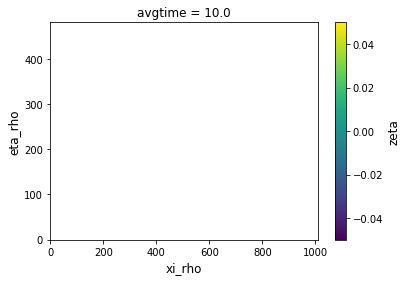

In [22]:
# Plot a result
plt.figure()
zeta_fp_std[10,...].plot()

In [ ]:
# Step 5: Save to "std" format file

# Create a file from template
infile = 'std_i_template.nc'
dsin = xr.open_dataset(infile)

# Create an output file
for t1 in times[0:-1]:

    daysince2000 = (t1-np.datetime64('2000-01-01')).total_seconds()/86400

    outfile = '../DATA/std_i_{}.nc'.format(int(daysince2000))

    dsin.to_netcdf(outfile)
    print(outfile)

In [19]:
varname = 'temp'
# Loop through and save all of the data to the file
for ii,t1 in enumerate(times[0:-1]):

    daysince2000 = (t1-np.datetime64('2000-01-01')).astype(float)*1e-9/86400

    outfile = '../DATA/std_i_{}.nc'.format(int(daysince2000))
    print('Saving {} for step {}'.format(varname,t1))
    
    # This is way quicker when working off the chunked zarr data
    zeta_f_time = zeta_fpc.sel(ocean_time = slice(t1-np.timedelta64(1,'D'), t1+np.timedelta64(5,'D'))).std(axis=0, keepdims=True)

    nc = Dataset(outfile, mode='r+')
    #nc['ocean_time'][0] = daysince2000
    #nc['zeta'][:] = zeta_fp_std[ii,...]
    # 2D variable
    #nc[varname][:] = zeta_f_time
    # 3D variable
    nc[varname][0,klayer,...] = zeta_f_time

    nc.close()



Saving temp for step 2017-02-01T00:00:00.000000000
Saving temp for step 2017-02-05T00:00:00.000000000
Saving temp for step 2017-02-09T00:00:00.000000000
Saving temp for step 2017-02-13T00:00:00.000000000
Saving temp for step 2017-02-17T00:00:00.000000000
Saving temp for step 2017-02-21T00:00:00.000000000
Saving temp for step 2017-02-25T00:00:00.000000000
Saving temp for step 2017-03-01T00:00:00.000000000
Saving temp for step 2017-03-05T00:00:00.000000000
Saving temp for step 2017-03-09T00:00:00.000000000
Saving temp for step 2017-03-13T00:00:00.000000000
Saving temp for step 2017-03-17T00:00:00.000000000
Saving temp for step 2017-03-21T00:00:00.000000000
Saving temp for step 2017-03-25T00:00:00.000000000
Saving temp for step 2017-03-29T00:00:00.000000000
Saving temp for step 2017-04-02T00:00:00.000000000
Saving temp for step 2017-04-06T00:00:00.000000000
Saving temp for step 2017-04-10T00:00:00.000000000
Saving temp for step 2017-04-14T00:00:00.000000000
Saving temp for step 2017-04-18

In [49]:
(t1-np.datetime64('2000-01-01')).astype(float)*1e-9/86400


6241.0

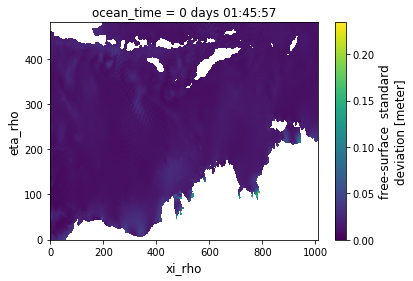

In [38]:
dsout = xr.open_dataset(outfile)

plt.figure()
dsout['zeta'].plot()

In [56]:
dsout.close()

# The real thing...



In [13]:
def write_filtered_var(myzeta, varname, is2d, klayer):
    
    for ii,t1 in enumerate(times[0:-1]):

        daysince2000 = (t1-np.datetime64('2000-01-01')).astype(float)*1e-9/86400

        outfile = '../DATA/std_i_{}.nc'.format(int(daysince2000))
        print('\tSaving {} for step {}'.format(varname,t1))

        # This is way quicker when working off the chunked zarr data
        zeta_f_time = myzeta.sel(ocean_time = slice(t1-np.timedelta64(1,'D'), t1+np.timedelta64(5,'D'))).std(axis=0, keepdims=True)

        nc = Dataset(outfile, mode='r+')
        #nc['ocean_time'][0] = daysince2000
        #nc['zeta'][:] = zeta_fp_std[ii,...]
        # 2D variable
        if is2d:
            nc[varname][:] = zeta_f_time
        else:
            # 3D variable
            nc[varname][0,klayer,...] = zeta_f_time

        nc.close()


In [16]:
varnames = ['zeta','ubar','vbar','temp','salt','u','v']
is2ds = [True, True, True, False, False, False, False]
klayers = 30

for varname, is2d in zip(varnames, is2ds):
    
    if varname in ['zeta','ubar','vbar','temp','salt']:
        continue
        
    #if varname in ['zeta','temp','salt']:
    #    xvar = 'eta_rho'
    #    yvar = 'xi_rho'
    
    print(72*'#')
    print('Filtering variable: ', varname)
    # Load the variable
    myroms # already done
    
    dt = myroms.ocean_time[1] - myroms.ocean_time[0]
    dtsec = dt.values.astype(float)*1e-9
    
    if is2d:
        zeta_f = filter_roms_2d(myroms, varname, cutoff_dt, dtsec)
        
        timevar, yvar, xvar = zeta_f.dims

        # Rechunk the data
        zeta_fpc = zeta_f.chunk({'ocean_time':1,yvar:-1,xvar:-1})
        zeta_fpc = zeta_fpc.persist()
        
        # Write
        write_filtered_var(zeta_fpc, varname, is2d, klayer)
    else:
        for klayer in range(klayers):
            print('Filtering layer: ', klayer)
            zeta_f = filter_roms_3d(myroms, varname, klayer, cutoff_dt, dtsec)
            
            timevar, yvar, xvar = zeta_f.dims

             # Rechunk the data
            zeta_fpc = zeta_f.chunk({'ocean_time':1,yvar:-1,xvar:-1})
            zeta_fpc = zeta_fpc.persist()
            
            # Write
            write_filtered_var(zeta_fpc, varname, is2d, klayer)
            
print('Done')
print(72*'#')


########################################################################
Filtering variable:  u
Filtering layer:  0
(0, 0, 0) 10800.0 122400.0
	Saving u for step 2017-02-01T00:00:00.000000000
	Saving u for step 2017-02-05T00:00:00.000000000
	Saving u for step 2017-02-09T00:00:00.000000000
	Saving u for step 2017-02-13T00:00:00.000000000
	Saving u for step 2017-02-17T00:00:00.000000000
	Saving u for step 2017-02-21T00:00:00.000000000
	Saving u for step 2017-02-25T00:00:00.000000000
	Saving u for step 2017-03-01T00:00:00.000000000
	Saving u for step 2017-03-05T00:00:00.000000000
	Saving u for step 2017-03-09T00:00:00.000000000
	Saving u for step 2017-03-13T00:00:00.000000000
	Saving u for step 2017-03-17T00:00:00.000000000
	Saving u for step 2017-03-21T00:00:00.000000000
	Saving u for step 2017-03-25T00:00:00.000000000
	Saving u for step 2017-03-29T00:00:00.000000000
	Saving u for step 2017-04-02T00:00:00.000000000
	Saving u for step 2017-04-06T00:00:00.000000000
	Saving u for step 2017-

	Saving u for step 2017-03-13T00:00:00.000000000
	Saving u for step 2017-03-17T00:00:00.000000000
	Saving u for step 2017-03-21T00:00:00.000000000
	Saving u for step 2017-03-25T00:00:00.000000000
	Saving u for step 2017-03-29T00:00:00.000000000
	Saving u for step 2017-04-02T00:00:00.000000000
	Saving u for step 2017-04-06T00:00:00.000000000
	Saving u for step 2017-04-10T00:00:00.000000000
	Saving u for step 2017-04-14T00:00:00.000000000
	Saving u for step 2017-04-18T00:00:00.000000000
	Saving u for step 2017-04-22T00:00:00.000000000
	Saving u for step 2017-04-26T00:00:00.000000000
	Saving u for step 2017-04-30T00:00:00.000000000
	Saving u for step 2017-05-04T00:00:00.000000000
	Saving u for step 2017-05-08T00:00:00.000000000
	Saving u for step 2017-05-12T00:00:00.000000000
	Saving u for step 2017-05-16T00:00:00.000000000
	Saving u for step 2017-05-20T00:00:00.000000000
	Saving u for step 2017-05-24T00:00:00.000000000
	Saving u for step 2017-05-28T00:00:00.000000000
Filtering layer:  6


	Saving u for step 2017-05-04T00:00:00.000000000
	Saving u for step 2017-05-08T00:00:00.000000000
	Saving u for step 2017-05-12T00:00:00.000000000
	Saving u for step 2017-05-16T00:00:00.000000000
	Saving u for step 2017-05-20T00:00:00.000000000
	Saving u for step 2017-05-24T00:00:00.000000000
	Saving u for step 2017-05-28T00:00:00.000000000
Filtering layer:  11
(0, 0, 0) 10800.0 122400.0
	Saving u for step 2017-02-01T00:00:00.000000000
	Saving u for step 2017-02-05T00:00:00.000000000
	Saving u for step 2017-02-09T00:00:00.000000000
	Saving u for step 2017-02-13T00:00:00.000000000
	Saving u for step 2017-02-17T00:00:00.000000000
	Saving u for step 2017-02-21T00:00:00.000000000
	Saving u for step 2017-02-25T00:00:00.000000000
	Saving u for step 2017-03-01T00:00:00.000000000
	Saving u for step 2017-03-05T00:00:00.000000000
	Saving u for step 2017-03-09T00:00:00.000000000
	Saving u for step 2017-03-13T00:00:00.000000000
	Saving u for step 2017-03-17T00:00:00.000000000
	Saving u for step 20

	Saving u for step 2017-02-21T00:00:00.000000000
	Saving u for step 2017-02-25T00:00:00.000000000
	Saving u for step 2017-03-01T00:00:00.000000000
	Saving u for step 2017-03-05T00:00:00.000000000
	Saving u for step 2017-03-09T00:00:00.000000000
	Saving u for step 2017-03-13T00:00:00.000000000
	Saving u for step 2017-03-17T00:00:00.000000000
	Saving u for step 2017-03-21T00:00:00.000000000
	Saving u for step 2017-03-25T00:00:00.000000000
	Saving u for step 2017-03-29T00:00:00.000000000
	Saving u for step 2017-04-02T00:00:00.000000000
	Saving u for step 2017-04-06T00:00:00.000000000
	Saving u for step 2017-04-10T00:00:00.000000000
	Saving u for step 2017-04-14T00:00:00.000000000
	Saving u for step 2017-04-18T00:00:00.000000000
	Saving u for step 2017-04-22T00:00:00.000000000
	Saving u for step 2017-04-26T00:00:00.000000000
	Saving u for step 2017-04-30T00:00:00.000000000
	Saving u for step 2017-05-04T00:00:00.000000000
	Saving u for step 2017-05-08T00:00:00.000000000
	Saving u for step 2

	Saving u for step 2017-04-14T00:00:00.000000000
	Saving u for step 2017-04-18T00:00:00.000000000
	Saving u for step 2017-04-22T00:00:00.000000000
	Saving u for step 2017-04-26T00:00:00.000000000
	Saving u for step 2017-04-30T00:00:00.000000000
	Saving u for step 2017-05-04T00:00:00.000000000
	Saving u for step 2017-05-08T00:00:00.000000000
	Saving u for step 2017-05-12T00:00:00.000000000
	Saving u for step 2017-05-16T00:00:00.000000000
	Saving u for step 2017-05-20T00:00:00.000000000
	Saving u for step 2017-05-24T00:00:00.000000000
	Saving u for step 2017-05-28T00:00:00.000000000
Filtering layer:  22
(0, 0, 0) 10800.0 122400.0
	Saving u for step 2017-02-01T00:00:00.000000000
	Saving u for step 2017-02-05T00:00:00.000000000
	Saving u for step 2017-02-09T00:00:00.000000000
	Saving u for step 2017-02-13T00:00:00.000000000
	Saving u for step 2017-02-17T00:00:00.000000000
	Saving u for step 2017-02-21T00:00:00.000000000
	Saving u for step 2017-02-25T00:00:00.000000000
	Saving u for step 20

	Saving u for step 2017-02-01T00:00:00.000000000
	Saving u for step 2017-02-05T00:00:00.000000000
	Saving u for step 2017-02-09T00:00:00.000000000
	Saving u for step 2017-02-13T00:00:00.000000000
	Saving u for step 2017-02-17T00:00:00.000000000
	Saving u for step 2017-02-21T00:00:00.000000000
	Saving u for step 2017-02-25T00:00:00.000000000
	Saving u for step 2017-03-01T00:00:00.000000000
	Saving u for step 2017-03-05T00:00:00.000000000
	Saving u for step 2017-03-09T00:00:00.000000000
	Saving u for step 2017-03-13T00:00:00.000000000
	Saving u for step 2017-03-17T00:00:00.000000000
	Saving u for step 2017-03-21T00:00:00.000000000
	Saving u for step 2017-03-25T00:00:00.000000000
	Saving u for step 2017-03-29T00:00:00.000000000
	Saving u for step 2017-04-02T00:00:00.000000000
	Saving u for step 2017-04-06T00:00:00.000000000
	Saving u for step 2017-04-10T00:00:00.000000000
	Saving u for step 2017-04-14T00:00:00.000000000
	Saving u for step 2017-04-18T00:00:00.000000000
	Saving u for step 2

	Saving v for step 2017-03-17T00:00:00.000000000
	Saving v for step 2017-03-21T00:00:00.000000000
	Saving v for step 2017-03-25T00:00:00.000000000
	Saving v for step 2017-03-29T00:00:00.000000000
	Saving v for step 2017-04-02T00:00:00.000000000
	Saving v for step 2017-04-06T00:00:00.000000000
	Saving v for step 2017-04-10T00:00:00.000000000
	Saving v for step 2017-04-14T00:00:00.000000000
	Saving v for step 2017-04-18T00:00:00.000000000
	Saving v for step 2017-04-22T00:00:00.000000000
	Saving v for step 2017-04-26T00:00:00.000000000
	Saving v for step 2017-04-30T00:00:00.000000000
	Saving v for step 2017-05-04T00:00:00.000000000
	Saving v for step 2017-05-08T00:00:00.000000000
	Saving v for step 2017-05-12T00:00:00.000000000
	Saving v for step 2017-05-16T00:00:00.000000000
	Saving v for step 2017-05-20T00:00:00.000000000
	Saving v for step 2017-05-24T00:00:00.000000000
	Saving v for step 2017-05-28T00:00:00.000000000
Filtering layer:  3
(0, 0, 0) 10800.0 122400.0
	Saving v for step 201

	Saving v for step 2017-05-08T00:00:00.000000000
	Saving v for step 2017-05-12T00:00:00.000000000
	Saving v for step 2017-05-16T00:00:00.000000000
	Saving v for step 2017-05-20T00:00:00.000000000
	Saving v for step 2017-05-24T00:00:00.000000000
	Saving v for step 2017-05-28T00:00:00.000000000
Filtering layer:  8
(0, 0, 0) 10800.0 122400.0
	Saving v for step 2017-02-01T00:00:00.000000000
	Saving v for step 2017-02-05T00:00:00.000000000
	Saving v for step 2017-02-09T00:00:00.000000000
	Saving v for step 2017-02-13T00:00:00.000000000
	Saving v for step 2017-02-17T00:00:00.000000000
	Saving v for step 2017-02-21T00:00:00.000000000
	Saving v for step 2017-02-25T00:00:00.000000000
	Saving v for step 2017-03-01T00:00:00.000000000
	Saving v for step 2017-03-05T00:00:00.000000000
	Saving v for step 2017-03-09T00:00:00.000000000
	Saving v for step 2017-03-13T00:00:00.000000000
	Saving v for step 2017-03-17T00:00:00.000000000
	Saving v for step 2017-03-21T00:00:00.000000000
	Saving v for step 201

	Saving v for step 2017-02-25T00:00:00.000000000
	Saving v for step 2017-03-01T00:00:00.000000000
	Saving v for step 2017-03-05T00:00:00.000000000
	Saving v for step 2017-03-09T00:00:00.000000000
	Saving v for step 2017-03-13T00:00:00.000000000
	Saving v for step 2017-03-17T00:00:00.000000000
	Saving v for step 2017-03-21T00:00:00.000000000
	Saving v for step 2017-03-25T00:00:00.000000000
	Saving v for step 2017-03-29T00:00:00.000000000
	Saving v for step 2017-04-02T00:00:00.000000000
	Saving v for step 2017-04-06T00:00:00.000000000
	Saving v for step 2017-04-10T00:00:00.000000000
	Saving v for step 2017-04-14T00:00:00.000000000
	Saving v for step 2017-04-18T00:00:00.000000000
	Saving v for step 2017-04-22T00:00:00.000000000
	Saving v for step 2017-04-26T00:00:00.000000000
	Saving v for step 2017-04-30T00:00:00.000000000
	Saving v for step 2017-05-04T00:00:00.000000000
	Saving v for step 2017-05-08T00:00:00.000000000
	Saving v for step 2017-05-12T00:00:00.000000000
	Saving v for step 2

	Saving v for step 2017-04-18T00:00:00.000000000
	Saving v for step 2017-04-22T00:00:00.000000000
	Saving v for step 2017-04-26T00:00:00.000000000
	Saving v for step 2017-04-30T00:00:00.000000000
	Saving v for step 2017-05-04T00:00:00.000000000
	Saving v for step 2017-05-08T00:00:00.000000000
	Saving v for step 2017-05-12T00:00:00.000000000
	Saving v for step 2017-05-16T00:00:00.000000000
	Saving v for step 2017-05-20T00:00:00.000000000
	Saving v for step 2017-05-24T00:00:00.000000000
	Saving v for step 2017-05-28T00:00:00.000000000
Filtering layer:  19
(0, 0, 0) 10800.0 122400.0
	Saving v for step 2017-02-01T00:00:00.000000000
	Saving v for step 2017-02-05T00:00:00.000000000
	Saving v for step 2017-02-09T00:00:00.000000000
	Saving v for step 2017-02-13T00:00:00.000000000
	Saving v for step 2017-02-17T00:00:00.000000000
	Saving v for step 2017-02-21T00:00:00.000000000
	Saving v for step 2017-02-25T00:00:00.000000000
	Saving v for step 2017-03-01T00:00:00.000000000
	Saving v for step 20

	Saving v for step 2017-02-05T00:00:00.000000000
	Saving v for step 2017-02-09T00:00:00.000000000
	Saving v for step 2017-02-13T00:00:00.000000000
	Saving v for step 2017-02-17T00:00:00.000000000
	Saving v for step 2017-02-21T00:00:00.000000000
	Saving v for step 2017-02-25T00:00:00.000000000
	Saving v for step 2017-03-01T00:00:00.000000000
	Saving v for step 2017-03-05T00:00:00.000000000
	Saving v for step 2017-03-09T00:00:00.000000000
	Saving v for step 2017-03-13T00:00:00.000000000
	Saving v for step 2017-03-17T00:00:00.000000000
	Saving v for step 2017-03-21T00:00:00.000000000
	Saving v for step 2017-03-25T00:00:00.000000000
	Saving v for step 2017-03-29T00:00:00.000000000
	Saving v for step 2017-04-02T00:00:00.000000000
	Saving v for step 2017-04-06T00:00:00.000000000
	Saving v for step 2017-04-10T00:00:00.000000000
	Saving v for step 2017-04-14T00:00:00.000000000
	Saving v for step 2017-04-18T00:00:00.000000000
	Saving v for step 2017-04-22T00:00:00.000000000
	Saving v for step 2

	Saving v for step 2017-03-29T00:00:00.000000000
	Saving v for step 2017-04-02T00:00:00.000000000
	Saving v for step 2017-04-06T00:00:00.000000000
	Saving v for step 2017-04-10T00:00:00.000000000
	Saving v for step 2017-04-14T00:00:00.000000000
	Saving v for step 2017-04-18T00:00:00.000000000
	Saving v for step 2017-04-22T00:00:00.000000000
	Saving v for step 2017-04-26T00:00:00.000000000
	Saving v for step 2017-04-30T00:00:00.000000000
	Saving v for step 2017-05-04T00:00:00.000000000
	Saving v for step 2017-05-08T00:00:00.000000000
	Saving v for step 2017-05-12T00:00:00.000000000
	Saving v for step 2017-05-16T00:00:00.000000000
	Saving v for step 2017-05-20T00:00:00.000000000
	Saving v for step 2017-05-24T00:00:00.000000000
	Saving v for step 2017-05-28T00:00:00.000000000
Done
########################################################################


#### 